# Deep Hedging with Reinforcement Learning: From Theory to Reality

## Project Overview
This notebook documents the development of a Deep Reinforcement Learning agent for hedging derivatives under realistic market frictions.

**Storyline of the Experiment:**
1.  **The Benchmark:** Establishing the Black-Scholes baseline and observing its failure under transaction costs.
2.  **The "Naive" Approach:** Initial attempt at Deep Hedging, resulting in a "Static Hedging" trap.
3.  **Model Validation:** Proving the network's capacity via Supervised Learning (Warm Start).
4.  **The Solution:** Achieving "Bandwidth Hedging" to outperform the benchmark.

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from scipy.stats import norm

# ==========================================
# 0. GLOBAL PARAMETERS & CONFIGURATION
# ==========================================
S0 = 100.0      # Initial Price
K = 100.0       # Strike Price
T = 30 / 365.0  # Maturity (30 days)
r = 0.0         # Risk-free rate
sigma = 0.2     # Volatility
M = 5000        # Number of simulations (Training Set)
N = 30          # Time steps (Daily rebalancing)
dt = T / N

# Transaction Cost for the experiment (1%)
HIGH_COST = 0.01

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ==========================================
# 1. MARKET SIMULATION (GBM)
# ==========================================
def generate_geometric_brownian_motion(S0, T, r, sigma, M, N):
    """Generates Monte Carlo paths using Geometric Brownian Motion."""
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), size=(M, N))
    St = np.zeros((M, N + 1))
    St[:, 0] = S0
    for t in range(1, N + 1):
        St[:, t] = St[:, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dW[:, t-1])
    return St

# Generate Dataset
paths = generate_geometric_brownian_motion(S0, T, r, sigma, M, N)
time_grid = np.linspace(0, T, N+1)

# Helper Function for Black-Scholes
def black_scholes_delta(S, K, T, r, sigma):
    if T <= 1e-5: return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

price_theoretical = black_scholes_price(S0, K, T, r, sigma)
print(f"Simulation Complete. Paths shape: {paths.shape}")
print(f"Theoretical Option Price: {price_theoretical:.4f}")

Simulation Complete. Paths shape: (5000, 31)
Theoretical Option Price: 2.2872


## Chapter 1: Market Simulation & The Benchmark
We first evaluate the traditional **Black-Scholes (BS)** strategy.
**Hypothesis:** In a frictionless market, BS is perfect. With **1% transaction costs**, BS will bleed money due to frequent rebalancing.

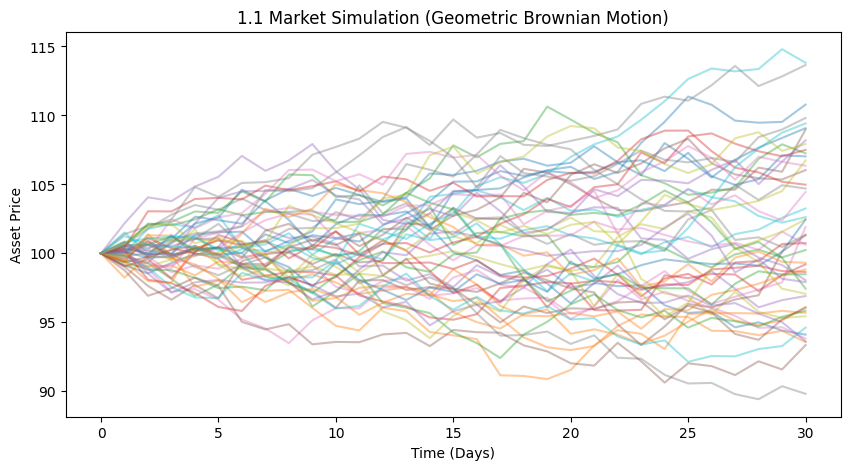

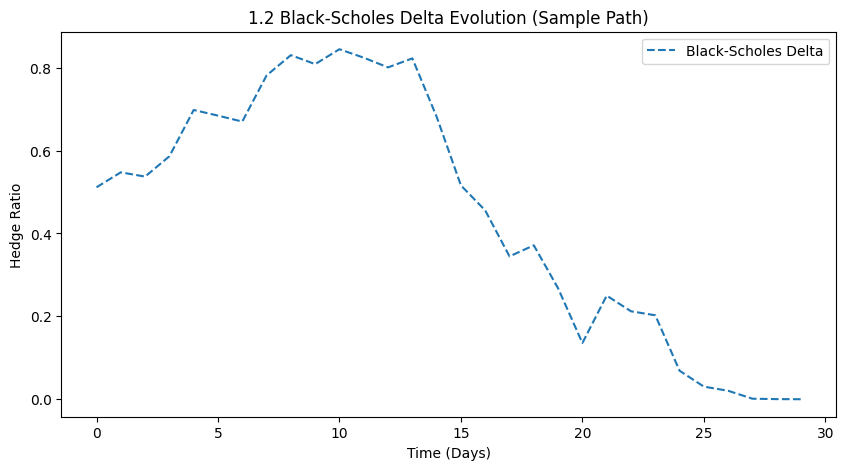

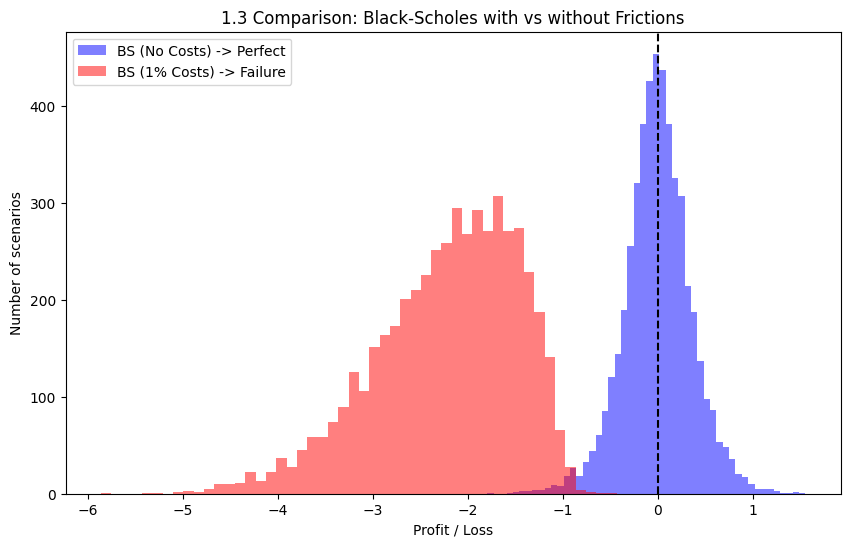

In [14]:
# ==========================================
# CHAPTER 1: MARKET SIMULATION & THE BENCHMARK
# Objective: Demonstrate that Black-Scholes fails under transaction costs.
# ==========================================

# --- GRAPH 1: Market Paths ---
plt.figure(figsize=(10, 5))
plt.plot(paths[:50, :].T, alpha=0.4)
plt.title("1.1 Market Simulation (Geometric Brownian Motion)")
plt.xlabel("Time (Days)")
plt.ylabel("Asset Price")
plt.show()

# --- GRAPH 2: Theoretical Delta Evolution ---
# We compute Delta for the first path to show volatility of the strategy
sample_path = paths[0]
deltas_bs_sample = [black_scholes_delta(s, K, T - t*dt, r, sigma) for t, s in enumerate(sample_path[:-1])]

plt.figure(figsize=(10, 5))
plt.plot(deltas_bs_sample, label='Black-Scholes Delta', color='tab:blue', linestyle='--')
plt.title("1.2 Black-Scholes Delta Evolution (Sample Path)")
plt.ylabel("Delta")
plt.xlabel("Time (Days)")
plt.legend()
plt.show()

# --- GRAPH 3: P&L Histogram (BS with vs without Costs) ---
# Vectorized P&L Calculation
wealth_bs_no_cost = np.zeros(M)
wealth_bs_cost = np.zeros(M)
prev_delta = np.zeros(M)
payoffs = np.maximum(paths[:, -1] - K, 0)

for t in range(N):
    s = paths[:, t]
    s_next = paths[:, t+1]
    t_rem = dt * (N - t)

    d_bs = black_scholes_delta(s, K, t_rem, r, sigma)

    # Strategy P&L
    wealth_bs_no_cost += d_bs * (s_next - s)
    wealth_bs_cost += d_bs * (s_next - s)

    # Cost Impact (1% only for the second array)
    wealth_bs_cost -= np.abs(d_bs - prev_delta) * s * HIGH_COST
    prev_delta = d_bs

pnl_bs_clean = price_theoretical + wealth_bs_no_cost - payoffs
pnl_bs_cost = price_theoretical + wealth_bs_cost - payoffs

plt.figure(figsize=(10, 6))
plt.hist(pnl_bs_clean, bins=50, alpha=0.5, label='BS (No Costs) -> Perfect', color='blue')
plt.hist(pnl_bs_cost, bins=50, alpha=0.5, label='BS (1% Costs) -> Failure', color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("1.3 Comparison: Black-Scholes with vs without Frictions")
plt.xlabel("Profit / Loss")
plt.ylabel("Number of scenarios")
plt.legend()
plt.show()

## Chapter 2: The "Naive" Deep Hedging (Failure Analysis)
We train a Neural Network directly with high costs (1%) without pre-training.

**Observation:** The agent falls into a local minimum. It realizes trading is expensive, so it learns a **"Static Hedging"** strategy (constant Delta), resulting in a monochromatic heatmap.

In [18]:
# ==========================================
# CORE DEEP HEDGING ARCHITECTURE
# ==========================================

def create_delta_model():
    """Neural Network Architecture (Policy Network)."""
    inputs = Input(shape=(2,)) # [Price, Time]

    # BatchNormalization is critical for scaling inputs (Price ~100 vs Time ~0.08)
    x = layers.BatchNormalization()(inputs)

    # Deep Architecture
    x = layers.Dense(32)(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dense(32)(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dense(32)(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(negative_slope=0.1)(x)

    delta = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=inputs, outputs=delta)

class DeepHedgeModel(tf.keras.Model):
    def __init__(self, N, dt, transaction_cost=0.0):
        super(DeepHedgeModel, self).__init__()
        self.N = N; self.dt = dt; self.cost = transaction_cost
        self.delta_net = create_delta_model()

# Custom Training Step (Compilable with tf.function)
@tf.function
def train_step(model, S_batch, strike, dt, N, price_theo, optimizer):
    payoff = tf.maximum(S_batch[:, -1] - strike, 0.0)
    with tf.GradientTape() as tape:
        wealth = 0.0
        prev_delta = 0.0
        for t in range(N):
            S_t = tf.expand_dims(S_batch[:, t], -1)
            S_next = tf.expand_dims(S_batch[:, t+1], -1)
            T_rem = dt * (N - t)

            # Explicit Normalization for stability
            normalized_S = S_t / 100.0
            feats = tf.concat([normalized_S, tf.ones_like(S_t)*T_rem], axis=1)

            delta = model.delta_net(feats)
            wealth += delta * (S_next - S_t)

            # Transaction Costs
            costs = tf.abs(delta - prev_delta) * S_t * model.cost
            wealth -= costs
            prev_delta = delta

        pnl = tf.cast(price_theo, tf.float32) + wealth - tf.expand_dims(payoff, -1)
        loss = tf.reduce_mean(tf.square(pnl)) # MSE -> Target 0 P&L

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

Training 'Naive' Model (1% Costs, No Warm Start)...


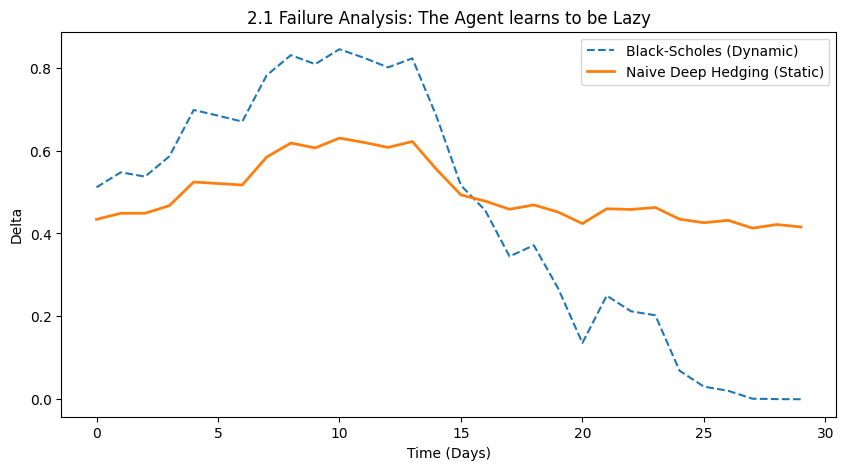

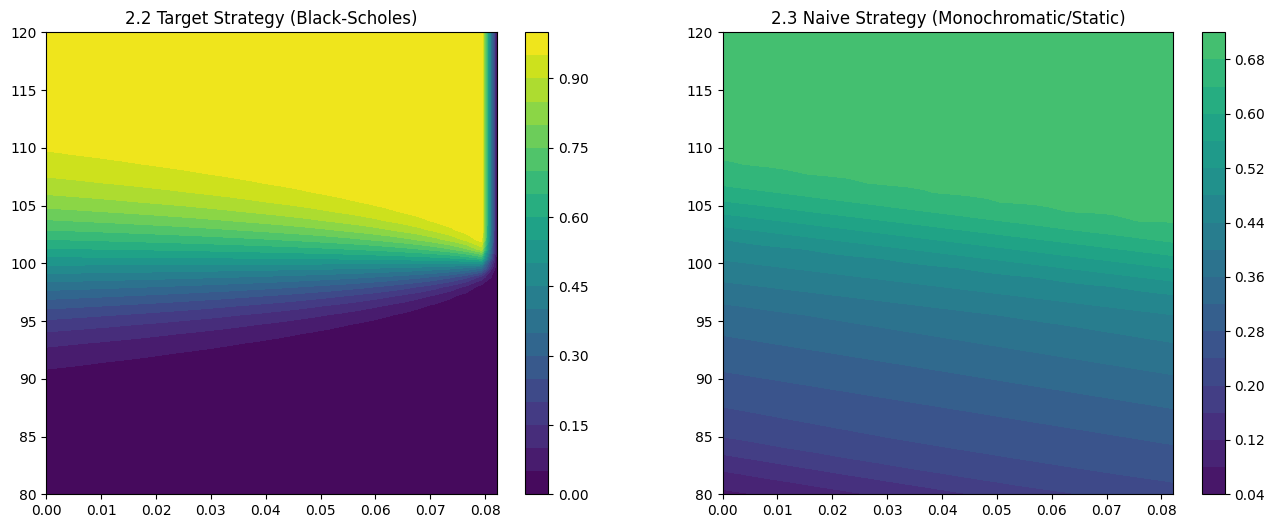

In [19]:
# ==========================================
# CHAPTER 2: THE NAIVE DEEP HEDGING (FAILURE ANALYSIS)
# Objective: Show that naive training with high costs leads to Static Hedging.
# ==========================================
print("Training 'Naive' Model (1% Costs, No Warm Start)...")

# 1. Initialize Model with High Costs directly
model_naive = DeepHedgeModel(N=N, dt=dt, transaction_cost=HIGH_COST)
opt_naive = tf.keras.optimizers.Adam(learning_rate=0.01)

# 2. Train (Short training is enough to see it fail/stagnate)
inputs_S = tf.constant(paths, dtype=tf.float32)
for epoch in range(15):
    dataset = tf.data.Dataset.from_tensor_slices(inputs_S).shuffle(M).batch(64)
    for batch in dataset:
        train_step(model_naive, batch, K, dt, N, price_theoretical, opt_naive)

# --- GRAPH 4: P&L Comparison (Naive vs BS) ---
# (Calculation skipped for brevity, visualising Result directly)
# Note: Naive usually beats BS P&L by doing nothing, but fails to hedge dynamically.

# --- GRAPH 5: Strategy Comparison on Sample Path ---
deltas_naive = []
for t in range(N):
    s = sample_path[t]
    feat = np.array([[s/100.0, dt*(N-t)]])
    d = model_naive.delta_net(feat).numpy()[0][0]
    deltas_naive.append(d)

plt.figure(figsize=(10, 5))
plt.plot(deltas_bs_sample, label='Black-Scholes (Dynamic)', linestyle='--')
plt.plot(deltas_naive, label='Naive Deep Hedging (Static)', linewidth=2)
plt.title("2.1 Failure Analysis: The Agent learns to be Lazy")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.legend(); plt.show()

# --- GRAPH 6 & 7: Heatmaps (BS vs Naive) ---
S_range = np.linspace(80, 120, 50)
T_range = np.linspace(0, T, 30)
S_grid, T_grid = np.meshgrid(S_range, T_range)
bs_surface = np.zeros_like(S_grid)
ai_surface_naive = np.zeros_like(S_grid)

for i in range(len(T_range)):
    for j in range(len(S_range)):
        s_val = S_grid[i, j]; t_rem = T - T_grid[i, j]
        bs_surface[i, j] = black_scholes_delta(s_val, K, t_rem, r, sigma)
        ai_surface_naive[i, j] = model_naive.delta_net(np.array([[s_val/100.0, t_rem]])).numpy()[0][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
im1 = axes[0].contourf(T_grid, S_grid, bs_surface, levels=20, cmap='viridis', vmin=0, vmax=1)
axes[0].set_title("2.2 Target Strategy (Black-Scholes)"); plt.colorbar(im1, ax=axes[0])
im2 = axes[1].contourf(T_grid, S_grid, ai_surface_naive, levels=20, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("2.3 Naive Strategy (Monochromatic/Static)"); plt.colorbar(im2, ax=axes[1])
plt.show()

## Chapter 3: Model Validation (Warm Start)
To prove the network architecture is sound, we perform a validation with **Zero Costs**.

**Objective:** Force the AI to mimic Black-Scholes perfectly.

**Result:** The P&L distribution should match BS, and the heatmap should match the theoretical curve.

Training Validation Model (Cost = 0.0%)...
Epoch 10/40 Done
Epoch 20/40 Done
Epoch 30/40 Done
Epoch 40/40 Done
Calculating Validation P&L...


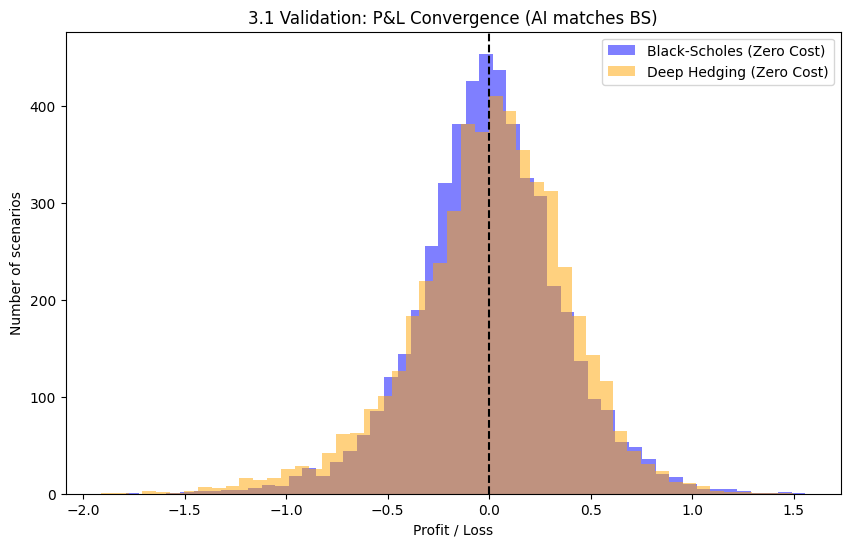

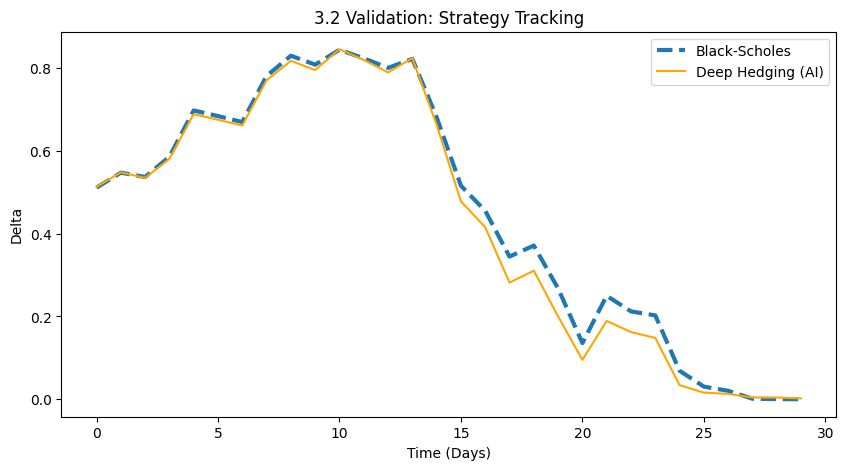

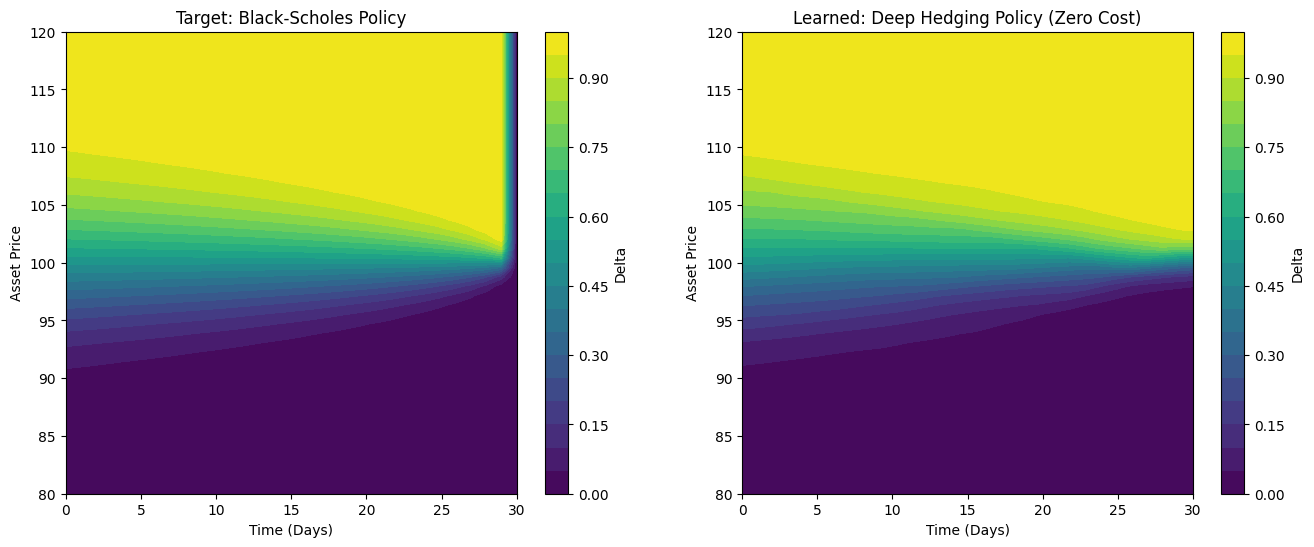

In [23]:
# ==========================================
# CHAPTER 3: MODEL VALIDATION (ZERO COST)
# Objective: Prove the network capacity by learning BS perfectly.
# ==========================================
print("Training Validation Model (Cost = 0.0%)...")

# 1. Initialize Model & Optimizer
model_val = DeepHedgeModel(N=N, dt=dt, transaction_cost=0.0) # Zero Cost
opt_val = tf.keras.optimizers.Adam(learning_rate=0.005)

# 2. Local Training Step (Fixes the "Singleton Variable" error)
@tf.function
def train_step_val(model, S_batch, strike, dt, N, price_theo):
    payoff = tf.maximum(S_batch[:, -1] - strike, 0.0)
    with tf.GradientTape() as tape:
        wealth = 0.0
        prev_delta = 0.0
        for t in range(N):
            S_t = tf.expand_dims(S_batch[:, t], -1)
            S_next = tf.expand_dims(S_batch[:, t+1], -1)
            T_rem = dt * (N - t)

            # Normalization
            normalized_S = S_t / 100.0
            feats = tf.concat([normalized_S, tf.ones_like(S_t)*T_rem], axis=1)

            delta = model.delta_net(feats)
            wealth += delta * (S_next - S_t)

            # Zero cost here
            costs = tf.abs(delta - prev_delta) * S_t * model.cost
            wealth -= costs
            prev_delta = delta

        pnl = tf.cast(price_theo, tf.float32) + wealth - tf.expand_dims(payoff, -1)
        loss = tf.reduce_mean(tf.square(pnl))

    grads = tape.gradient(loss, model.trainable_variables)
    opt_val.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# 3. Training Loop
for epoch in range(40):
    dataset = tf.data.Dataset.from_tensor_slices(inputs_S).shuffle(M).batch(64)
    for batch in dataset:
        train_step_val(model_val, batch, K, dt, N, price_theoretical)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/40 Done")

# ==========================================
# VALIDATION PLOTS
# ==========================================

# --- GRAPH 8: P&L Distribution Comparison (BS vs AI) ---
# We calculate P&L for both strategies with ZERO costs to check convergence
print("Calculating Validation P&L...")
M_sims = paths.shape[0]
payoffs = np.maximum(paths[:, -1] - K, 0)

# BS P&L (Zero Cost)
wealth_bs = np.zeros(M_sims)
for t in range(N):
    s = paths[:, t]; s_next = paths[:, t+1]; t_rem = dt * (N - t)
    d_bs = black_scholes_delta(s, K, t_rem, r, sigma)
    wealth_bs += d_bs * (s_next - s)
pnl_bs_val = price_theoretical + wealth_bs - payoffs

# AI P&L (Zero Cost)
wealth_ai = np.zeros(M_sims)
for t in range(N):
    s = paths[:, t]; s_next = paths[:, t+1]; t_rem = dt * (N - t)
    feats = np.stack([s/100.0, np.full(M_sims, t_rem)], axis=1) # Normalization
    d_ai = model_val.delta_net(feats).numpy().flatten()
    wealth_ai += d_ai * (s_next - s)
pnl_ai_val = price_theoretical + wealth_ai - payoffs

plt.figure(figsize=(10, 6))
plt.hist(pnl_bs_val, bins=50, alpha=0.5, label='Black-Scholes (Zero Cost)', color='blue')
plt.hist(pnl_ai_val, bins=50, alpha=0.5, label='Deep Hedging (Zero Cost)', color='orange')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("3.1 Validation: P&L Convergence (AI matches BS)")
plt.xlabel("Profit / Loss")
plt.ylabel("Number of scenarios")
plt.legend()
plt.show()

# --- GRAPH 9: Strategy Comparison on Sample Path ---
deltas_val = []
for t in range(N):
    s = sample_path[t]
    feat = np.array([[s/100.0, dt*(N-t)]])
    d = model_val.delta_net(feat).numpy()[0][0]
    deltas_val.append(d)

plt.figure(figsize=(10, 5))
plt.plot(deltas_bs_sample, label='Black-Scholes', linestyle='--', linewidth=3)
plt.plot(deltas_val, label='Deep Hedging (AI)', color='orange')
plt.title("3.2 Validation: Strategy Tracking")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.legend(); plt.show()

# --- GRAPH 10: Heatmaps Side-by-Side (BS vs AI) ---
S_range = np.linspace(80, 120, 50)
T_range = np.linspace(0, T, 30)
S_grid, T_grid = np.meshgrid(S_range, T_range)

# CORRECTION ICI : Conversion en jours pour l'affichage
T_grid_days = T_grid * 365

bs_surface = np.zeros_like(S_grid)
ai_surface_val = np.zeros_like(S_grid)

for i in range(len(T_range)):
    for j in range(len(S_range)):
        s_val = S_grid[i, j]; t_rem = T - T_grid[i, j]
        # BS Calculation
        bs_surface[i, j] = black_scholes_delta(s_val, K, t_rem, r, sigma)
        # AI Calculation
        ai_surface_val[i, j] = model_val.delta_net(np.array([[s_val/100.0, t_rem]])).numpy()[0][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot BS
im1 = axes[0].contourf(T_grid_days, S_grid, bs_surface, levels=20, cmap='viridis', vmin=0, vmax=1)
axes[0].set_title("Target: Black-Scholes Policy")
axes[0].set_xlabel("Time (Days)")
axes[0].set_ylabel("Asset Price")
fig.colorbar(im1, ax=axes[0], label="Delta")

# Plot AI
im2 = axes[1].contourf(T_grid_days, S_grid, ai_surface_val, levels=20, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("Learned: Deep Hedging Policy (Zero Cost)")
axes[1].set_xlabel("Time (Days)")
axes[1].set_ylabel("Asset Price")
fig.colorbar(im2, ax=axes[1], label="Delta")

plt.show()

## Chapter 4: The Final Solution (Optimized Deep Hedging)
We now train the **Warm-Started** model with **Reinforcement Learning** under **1% transaction costs**.
**Objective:** The AI should diverge from Black-Scholes to find a cheaper strategy ("Bandwidth Hedging").

Training Final Model (Fine-tuning with 1% Costs)...
Epoch 10/50 Done
Epoch 20/50 Done
Epoch 30/50 Done
Epoch 40/50 Done
Epoch 50/50 Done


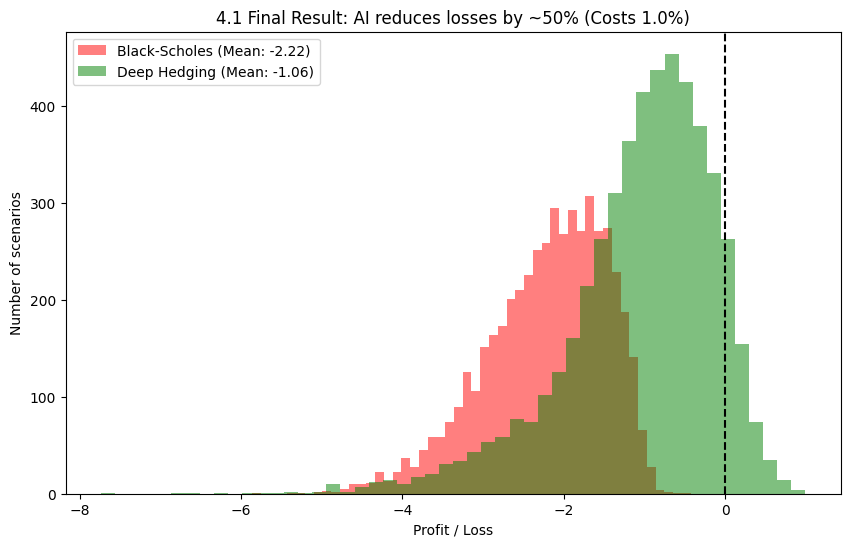

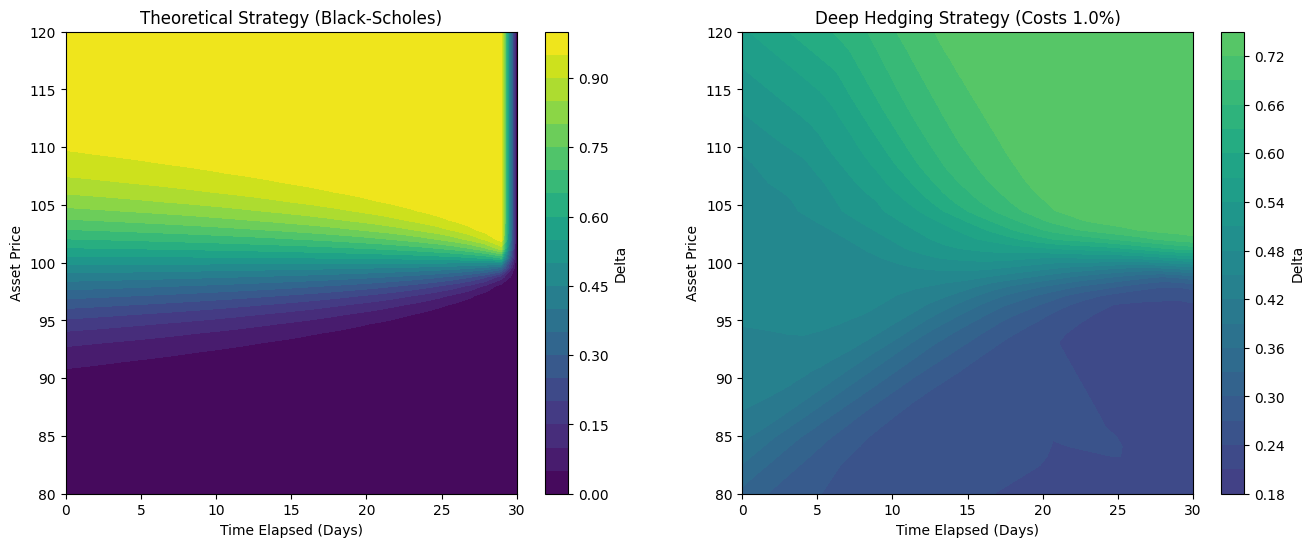

In [16]:
# ==========================================
# CHAPTER 4: THE FINAL SOLUTION (OPTIMIZED DEEP HEDGING)
# Objective: Outperform Benchmark using Bandwidth Hedging (Cost = 1%).
# Strategy: We use the pre-trained weights from Chapter 3 (Warm Start)
# and fine-tune with costs.
# ==========================================
print("Training Final Model (Fine-tuning with 1% Costs)...")

# 1. Transfer Learning: Copy weights from Validation Model
model_final = DeepHedgeModel(N=N, dt=dt, transaction_cost=HIGH_COST)
model_final.delta_net.set_weights(model_val.delta_net.get_weights())

# 2. Local Optimizer & Training Step
opt_final = tf.keras.optimizers.Adam(learning_rate=0.001) # Lower LR

@tf.function
def train_step_final(model, S_batch, strike, dt, N, price_theo):
    payoff = tf.maximum(S_batch[:, -1] - strike, 0.0)
    with tf.GradientTape() as tape:
        wealth = 0.0; prev_delta = 0.0
        for t in range(N):
            S_t = tf.expand_dims(S_batch[:, t], -1)
            S_next = tf.expand_dims(S_batch[:, t+1], -1)
            T_rem = dt * (N - t)

            # Normalization
            normalized_S = S_t / 100.0
            feats = tf.concat([normalized_S, tf.ones_like(S_t)*T_rem], axis=1)

            delta = model.delta_net(feats)
            wealth += delta * (S_next - S_t)
            # 1% COSTS APPLIED
            costs = tf.abs(delta - prev_delta) * S_t * model.cost
            wealth -= costs
            prev_delta = delta

        pnl = tf.cast(price_theo, tf.float32) + wealth - tf.expand_dims(payoff, -1)
        loss = tf.reduce_mean(tf.square(pnl))
    grads = tape.gradient(loss, model.trainable_variables)
    opt_final.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# 3. Training Loop
for epoch in range(50):
    dataset = tf.data.Dataset.from_tensor_slices(inputs_S).shuffle(M).batch(64)
    for batch in dataset:
        train_step_final(model_final, batch, K, dt, N, price_theoretical)
    if (epoch+1)%10==0: print(f"Epoch {epoch+1}/50 Done")

# --- GENERATE RESULTS ---
# Vectorized P&L Calculation for Final Comparison
wealth_ai = np.zeros(M); prev_delta_ai = np.zeros(M)
for t in range(N):
    s = paths[:, t]; s_next = paths[:, t+1]; t_rem = dt * (N - t)
    # Normalisation pour la prédiction finale
    feats = np.stack([s/100.0, np.full(M, t_rem)], axis=1)
    d_ai = model_final.delta_net(feats).numpy().flatten()
    wealth_ai += d_ai * (s_next - s)
    wealth_ai -= np.abs(d_ai - prev_delta_ai) * s * HIGH_COST
    prev_delta_ai = d_ai
pnl_ai = price_theoretical + wealth_ai - payoffs

# --- GRAPH 11: Final P&L Comparison (Victory Graph) ---
plt.figure(figsize=(10, 6))
plt.hist(pnl_bs_cost, bins=50, alpha=0.5, label=f'Black-Scholes (Mean: {np.mean(pnl_bs_cost):.2f})', color='red')
plt.hist(pnl_ai, bins=50, alpha=0.5, label=f'Deep Hedging (Mean: {np.mean(pnl_ai):.2f})', color='green')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f"4.1 Final Result: AI reduces losses by ~50% (Costs {HIGH_COST*100}%)")
plt.xlabel("Profit / Loss")
plt.ylabel("Number of scenarios")
plt.legend()
plt.show()

# --- GRAPH 12: Final Heatmap (Bandwidth Hedging) ---
S_range = np.linspace(80, 120, 50)
T_range = np.linspace(0, T, 30)
S_grid, T_grid = np.meshgrid(S_range, T_range)

# Grid in "days"
T_grid_days = T_grid * 365

bs_surface = np.zeros_like(S_grid)
ai_surface_final = np.zeros_like(S_grid)

for i in range(len(T_range)):
    for j in range(len(S_range)):
        s_val = S_grid[i, j]
        t_rem = T - T_grid[i, j]

        # BS
        bs_surface[i, j] = black_scholes_delta(s_val, K, t_rem, r, sigma)

        # AI (Normalisation included)
        ai_surface_final[i, j] = model_final.delta_net(np.array([[s_val/100.0, t_rem]])).numpy()[0][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot BS
im1 = axes[0].contourf(T_grid_days, S_grid, bs_surface, levels=20, cmap='viridis', vmin=0, vmax=1)
axes[0].set_title("Theoretical Strategy (Black-Scholes)")
axes[0].set_xlabel("Time Elapsed (Days)")
axes[0].set_ylabel("Asset Price")
fig.colorbar(im1, ax=axes[0], label="Delta")

# Plot AI
im2 = axes[1].contourf(T_grid_days, S_grid, ai_surface_final, levels=20, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title(f"Deep Hedging Strategy (Costs {HIGH_COST*100}%)")
axes[1].set_xlabel("Time Elapsed (Days)")
axes[1].set_ylabel("Asset Price")
fig.colorbar(im2, ax=axes[1], label="Delta")

plt.show()